In [1]:
import torch
import numpy as np
import torchvision.transforms as transforms              
from torchvision.datasets import CIFAR10      
from torch.utils.data import DataLoader
from src.temperature_scaling import ModelWithTemperature
from src.aps_real_probs import split_data_set_cifar10h, saps_scores_real_probs, saps_classification_cifar10h, eval_aps_real_probs
from src.inception import inception_v3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dict_path = "C:\\Users\\jiayang\\ipynb\\trainedModel\\Inception_CIFAR10.pth"
model = inception_v3(pretrained=True, dict_path=dict_path).to(device)

# preprocess the images from CIFAR10
data_transform = transforms.Compose([
    transforms.ToTensor(),       
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  
])

# load images from CIFAR10
dataset = CIFAR10(root="../data", train=False, download=True, transform=data_transform)

# Temperature Scaling
temp_scal_loader = DataLoader(dataset, batch_size=32, shuffle=True)
model = ModelWithTemperature(model, temperature=5.2).to(device)
model.set_temperature(temp_scal_loader)
model.eval()

# The number of times the experiment is going to be repeated
num_runs = 10

# error rate
alpha = 0.1
# Hyperparameter
lambda_ = 1.0

# construct and evaluate repeatedly
all_avg_set_sizes = []
all_avg_coverages = []
all_avg_real_probs = []
all_real_probs_distribution = []  # sum of real prob for histogram

print("SAPS Classification, Start!\n")
for i in range(num_runs):
    print(f"Running experiment {i+1}/{num_runs}...")

    # split dataset
    calib_dataset, test_dataset = split_data_set_cifar10h(dataset, random_seed=i)

    # load data set respectively
    calib_loader = DataLoader(calib_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # calculate q_hat
    calib_scores, _ = saps_scores_real_probs(model, calib_loader, alpha, lambda_, device)
    q_hat = np.quantile(calib_scores, 1 - 0.1)  # calculate 1-alpha quantile

    # construct APS
    aps, aps_labels, true_labels, real_probs = saps_classification_cifar10h(model, test_loader, q_hat, lambda_, device)

    # evaluate APS
    avg_set_size, avg_coverage = eval_aps_real_probs(aps_labels, true_labels)
    sum_real_probs = [sum(probs) for probs in real_probs]
    avg_real_prob = np.mean(sum_real_probs)  # average real probability
 
    # record current result
    all_avg_set_sizes.append(avg_set_size)
    all_avg_coverages.append(avg_coverage)
    all_avg_real_probs.append(avg_real_prob)
    all_real_probs_distribution.extend(sum_real_probs)

# calculate the final average result
final_avg_set_size = np.mean(all_avg_set_sizes)
final_avg_coverage = np.mean(all_avg_coverages)
final_avg_real_prob = np.mean(all_avg_real_probs)
final_set_size_std = np.std(all_avg_set_sizes, ddof=0)
final_coverage_std = np.std(all_avg_coverages, ddof=0)
final_real_prob_std = np.std(all_avg_real_probs, ddof=0)

print(f"Final Average Prediction Set Size: {final_avg_set_size:.2f} ± {final_set_size_std:.2f}")
print(f"Final Average Coverage: {final_avg_coverage:.4f} ± {final_coverage_std:.4f}")
print(f"Final Average Real Probability: {final_avg_real_prob:.4f} ± {final_real_prob_std:.4f}")

Loading weights from: C:\Users\jiayang\ipynb\trainedModel\Inception_CIFAR10.pth
Files already downloaded and verified
Before temperature - NLL: 0.419, ECE: 0.054
Optimal temperature: 5.128
After temperature - NLL: 0.766, ECE: 0.338
SAPS Classification, Start!

Running experiment 1/10...
Running experiment 2/10...
Running experiment 3/10...
Running experiment 4/10...
Running experiment 5/10...
Running experiment 6/10...
Running experiment 7/10...
Running experiment 8/10...
Running experiment 9/10...
Running experiment 10/10...
Final Average Prediction Set Size: 1.18 ± 0.01
Final Average Coverage: 0.9006 ± 0.0057
Final Average Real Probability: 0.8739 ± 0.0055


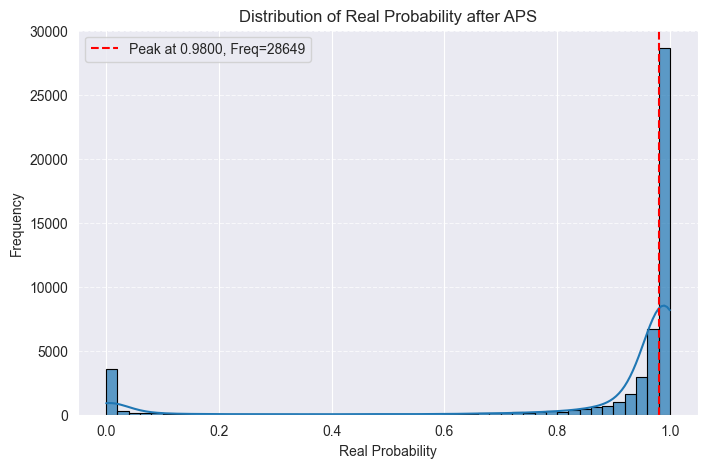

 28649( 57.30%) Samples Reached the Peak of Real Probability at 0.9800 


In [2]:
import seaborn as sb
from matplotlib import pyplot as plt

# sort real probability
sorted_probs = np.sort(all_real_probs_distribution)

# find the peak value ( the most frequent real probability, frequency)
y_axis, x_axis = np.histogram(sorted_probs, bins=50)
peak_y = max(y_axis)  # frequency
peak_x = x_axis[np.argmax(y_axis)] # the most frequent real probability

# draw the histogram
plt.figure(figsize=(8, 5))
sb.histplot(sorted_probs, bins=50, kde=True, edgecolor='black', alpha=0.7)
plt.xlabel("Real Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Real Probability after APS")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# mark the peak
plt.axvline(peak_x, color='red', linestyle='--', label=f'Peak at {peak_x:.4f}, Freq={peak_y}')
plt.legend()

plt.show()

peak_coverage = peak_y / len(sorted_probs) * 100
print(f" {peak_y}({peak_coverage: .2f}%) Samples Reached the Peak of Real Probability at {peak_x:.4f} ")